## **Forward Pass Summary**

In [14]:
import numpy as np
import nnfs
from nnfs.datasets import spiral_data
import matplotlib.pyplot as plt

In [3]:
nnfs.init() # Load the data

In [4]:
# Forward Pass

class Layer_Dense:

    # Layer initialization
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    # Forward pass
    def forward(self, inputs):
        # Calculate output values from inputs, weights and biases
        self.output = np.dot(inputs, self.weights) + self.biases

In [5]:
# Activation Functions

class Activation_ReLU:

    # Forward pass
    def forward(self, inputs):
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)

class Activation_Softmax:

    # Forward pass
    def forward(self, inputs):

        # Get unnormalized probabilities
        exp_values = np.exp(inputs - np.max(inputs, axis=1,
                                            keepdims=True))
        # Normalize them for each sample
        probabilities = exp_values / np.sum(exp_values, axis=1,
                                            keepdims=True)

        self.output = probabilities

In [11]:
# Compute the Loss with softmax

# Common loss class
class Loss:

    # Calculates the data and regularization losses
    # given model output and ground truth values
    def calculate(self, output, y):

        # Calculate sample losses
        sample_losses = self.forward(output, y)
        

        # Calculate mean loss
        data_loss = np.mean(sample_losses)

        # Return loss
        return data_loss

class Loss_CategoricalCrossentropy(Loss):

    # Forward pass
    def forward(self, y_pred, y_true):

        # Number of samples in a batch
        samples = len(y_pred)

        # Clip data to prevent division by 0
        # Clip both sides to not drag mean towards any value
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)


        # Probabilities for target values -
        # only if categorical labels
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[
                range(samples),
                y_true
            ]

        # Mask values - only for one-hot encoded labels
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(
                y_pred_clipped*y_true,
                axis=1
            )

        # Losses
        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

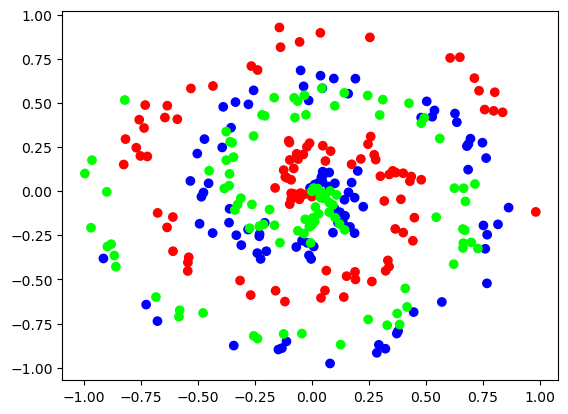

In [19]:

# Create dataset
X, y = spiral_data(samples=100, classes=3)

plt.scatter(X[:,0], X[:,1], c=y, cmap = 'brg')
plt.show()
# print(X)
# print(y)

In [20]:
# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)

# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()

# Create second Dense layer with 3 input features (as we take output
# of previous layer here) and 3 output values
dense2 = Layer_Dense(3, 3)

# Create Softmax activation (to be used with Dense layer):
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossentropy()

# Perform a forward pass of our training data through this layer
dense1.forward(X)

# Perform a forward pass through activation function
# it takes the output of first dense layer here
activation1.forward(dense1.output)


# Perform a forward pass through second Dense layer
# it takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)

# Perform a forward pass through activation function
# it takes the output of second dense layer here
activation2.forward(dense2.output)

# Let's see output of the first few samples:
print(activation2.output[:10])

# Perform a forward pass through loss function
# it takes the output of second dense layer here and returns loss
loss = loss_function.calculate(activation2.output, y)

# Print loss value
print('loss:', loss)

[[0.33333334 0.33333334 0.33333334]
 [0.33333313 0.33333358 0.33333328]
 [0.33333293 0.33333385 0.33333322]
 [0.33333325 0.3333334  0.3333333 ]
 [0.3333329  0.3333339  0.33333322]
 [0.33333296 0.3333338  0.33333322]
 [0.33333293 0.33333385 0.33333322]
 [0.3333331  0.33333364 0.33333328]
 [0.33333334 0.33333334 0.33333334]
 [0.3333326  0.33333433 0.33333313]]
loss: 1.0986073


In [27]:
# Accuracy is easier to interpret

predictions = activation2.output
predictions = np.argmax(predictions, axis=1)
accuracy = np.mean(predictions==y)
print('accuracy:', accuracy)

accuracy: 0.38


## **Calculus Recap**

In this section, we revisit essential concepts from calculus that form the foundation of gradient-based optimization techniques in neural networks. Specifically, we will cover **partial derivatives**, the **gradient**, and the **chain rule**. These tools are crucial for understanding and implementing the backpropagation algorithm, which enables neural networks to learn from data.

---

### **Partial Derivatives**

Partial derivatives are a generalization of ordinary derivatives to functions of multiple variables. When a function $f(x_1, x_2, \dots, x_n)$ depends on several variables, the partial derivative with respect to one of these variables measures how $f$ changes when that specific variable changes, while all other variables remain constant.

The partial derivative of $f$ with respect to $x_i$ is denoted as:

$$
\frac{\partial f}{\partial x_i}
$$

For example, if $f(x, y) = x^2 + 3xy + y^2$, the partial derivatives are:

$$
\frac{\partial f}{\partial x} = 2x + 3y, \quad \frac{\partial f}{\partial y} = 3x + 2y
$$

---

### **The Gradient**

The gradient of a scalar function $f(x_1, x_2, \dots, x_n)$ is a vector that points in the direction of the steepest ascent of $f$. It is composed of all the partial derivatives of $f$ with respect to its variables:

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x_1} \\
\frac{\partial f}{\partial x_2} \\
\vdots \\
\frac{\partial f}{\partial x_n}
\end{bmatrix}
$$

For the same example $f(x, y) = x^2 + 3xy + y^2$, the gradient is:

$$
\nabla f = \begin{bmatrix}
\frac{\partial f}{\partial x} \\
\frac{\partial f}{\partial y}
\end{bmatrix} =
\begin{bmatrix}
2x + 3y \\
3x + 2y
\end{bmatrix}
$$

The gradient is a key concept in gradient descent, as it guides us in updating parameters to minimize a given loss function.

---

### **The Chain Rule**

The chain rule allows us to compute the derivative of a composite function. If $z$ depends on $y$, and $y$ depends on $x$, then the rate of change of $z$ with respect to $x$ can be found using:

$$
\frac{dz}{dx} = \frac{dz}{dy} \cdot \frac{dy}{dx}
$$

In the context of partial derivatives, if $f$ is a function of $u_1, u_2, \dots, u_m$, and each $u_i$ is a function of $x_1, x_2, \dots, x_n$, the chain rule is expressed as:

$$
\frac{\partial f}{\partial x_j} = \sum_{i=1}^m \frac{\partial f}{\partial u_i} \cdot \frac{\partial u_i}{\partial x_j}
$$

The chain rule is particularly important in neural networks for calculating gradients through layers of non-linear transformations.

---

By combining these concepts—partial derivatives, gradients, and the chain rule—we can derive the mathematical framework for **gradient descent**, the algorithm that enables neural networks to optimize their parameters and learn from data.


# **Lecture 5: Backpropagation**